# Implicit QoS - Shannon Tokenomics


This notebook pretends to analyze the proposed tokenomics scenario presented [here](https://www.notion.so/buildwithgrove/MVP-Tokenomics-a702fd0d07dd4e288a4c62bb579202d0).
We used the described 3 out of 4 sessions in the low 3 of the ranked list of used nodes in each session to implement the penalties.
Everything is calculated for 15K stake nodes (PIP-22 must RIP)

There are two approaches presented, an statistical aproach and a numerical one.
The work is not finished but in this state some importat conclusion can be drawn:
- Owning more than 5% of the nodes in any chain results in an effective self deal attack that can generate more than 10K POKT/Month on fake trafic.
- Round-Robin of nodes results in a penalization probability for honest nodes of 0.06% and this increases if the adversary is activelly self dealing (not Round-Robing).




### Done:
- [x] Implement session granularity
- [x] Add apps status (honest / adversary) [added in name]
- [x] Add servicer status (honest / adversary) [added in name]
- [x] Track per-app and per-servicer relays
- [x] Implement self-dealing of adversary apps / servicers
- [x] Implement implicit QoS tracking using botom N nodes in last M sessions
- [x] Implement modifiable experiment classes
### Doing:
- [/] Test effects on low-use services
### To Do:
- [ ] Implement implicit QoS enhancements / guardrails
- [ ] Implement slashing and jailing
- [ ] Test effects of gardrails



In [1]:
from scipy.stats import binom
from scipy.stats import hypergeom
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy

# Stats Approach

Below is the description of the self deal attack using honest nodes. This attack is not covered by the current guardrails.
The attack consists of an attacker that owns a given amount of honest nodes (a node runner or a node runner client) that stakes an app wich will only produce relays when his/hers nodes are on a session, otherwise the app will skip the session.
This model calculates the requiered time for the attacker to recover the staked POKT in th app used for the attack.

In [2]:
# https://poktscan.com/app/c7aba112f66063d998151c251166540fb4c1eda7
app_stake = 10000e6 # uPOKT
max_relays_per_session = 20000000


burn_per_relay = (0.00000085/0.2)*1e6 # Current price at pokt 0.2
mint_per_relay = 0.000443*1e6 # on 12/03

In [3]:
def calc_attack_stats(num_adversary_nodes, total_nodes, fraction_of_max_relays_use = 1/10):
    '''
    This calculation ises an Hypergeometric distribution to calculate the chances of 
    adversary aps and nodes to be selected in the same session. While a binomial
    gives in similar results, it has an increasing error as the number of nodes 
    staked in the service goes down (something of particular interest to us).
    For this reason, and due to the low volume of data, the Hypergeometric function 
    is used.
    '''

    # Number of nodes to pick
    nodes_per_session = 24

    # Minimum successes needed (at least 1 adversary node) to procede to self-deal
    
    # Binomial distribution
    # p_success = num_adversary_nodes/(total_nodes)
    # k = 1
    # prob_at_least_one_success = 1 - binom.cdf(k-1, nodes_per_session, p_success)
    # Hypergeometric Distribution
    prob_at_least_one_success = hypergeom.pmf(k=range(1, nodes_per_session), M=total_nodes, n=num_adversary_nodes, N=nodes_per_session).sum()

    # Expected number of nodes in each session:
    # Binomial distribution
    # e_nodes_session = p_success*nodes_per_session
    # Hypergeometric Distribution
    e_nodes_session = hypergeom(M=total_nodes, n=num_adversary_nodes, N=nodes_per_session).mean()

    # For each normal relay you win, on average, per node:
    honest_win = mint_per_relay*(1-0.1-0.05)/nodes_per_session
    # Thats the total minted per unit relay, minus the validators and DAO take 
    # and divided by the worst case scnario when all nodes in the session
    # collect part of the total reward pool.

    # For each session and relay, the expected win is:
    e_self_deal_win = ((e_nodes_session*honest_win)-burn_per_relay)
    # The expected number of adversary nodes in the session multiplied the 
    # income of a single relay minus what the adversary needs to pay for that relay

    # Number of session to pay for app stake
    e_num_sessions = app_stake/(e_self_deal_win*max_relays_per_session*fraction_of_max_relays_use*prob_at_least_one_success)
    # The total app_stake invested by the adversary is paid by seld dealing on 
    # sessions that include at least one of his/hers nodes. This last part is
    # enforced by means of the probability of obtaining such session.

    # Retuen expected number of blocks, sessions and days untill app stake recovery.
    return e_num_sessions*4, e_num_sessions, e_num_sessions/24


In [4]:
# Calculate effect of chain dominance
test_rows = list()
# For a given service with different amount of total nodes staked
for total_chain_nodes in np.linspace(100,15000,10):
    # And an adversary dominating the given fraction if that number of nodes
    for prop_nodes_ownership in np.geomspace(0.05,0.9,10):
        # Convert to int
        attacker_nodes = int(prop_nodes_ownership*total_chain_nodes)
        prop_nodes_ownership = np.round(prop_nodes_ownership, decimals=2)
        attacker_nodes = int(attacker_nodes)
        total_chain_nodes = int(total_chain_nodes)
        # Calculate the stats model
        e_num_blocks, e_num_sessions, e_days_to_attack_cover = calc_attack_stats(attacker_nodes, total_chain_nodes, fraction_of_max_relays_use = 1/10)
        # Add to row
        test_rows.append((total_chain_nodes, prop_nodes_ownership, attacker_nodes, e_num_sessions, e_days_to_attack_cover))
# Create DatafRame
prob_df = pd.DataFrame(test_rows, columns=['total_nodes', 'attacker_ownership_prop', 'attacker_nodes', 'sessions', 'days'])

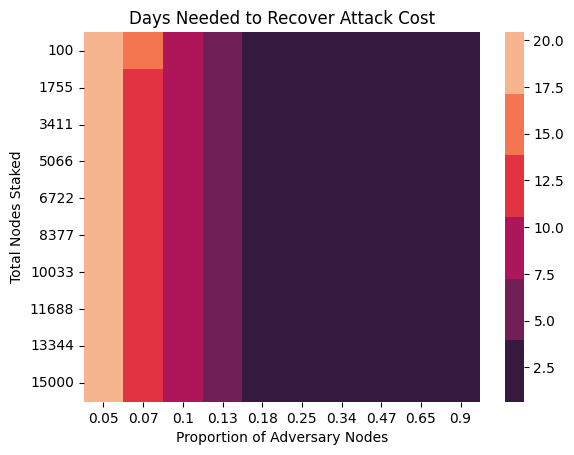

In [5]:
plt.figure()
plt.title('Days Needed to Recover Attack Cost')
sns.heatmap(pd.pivot_table(prob_df, values='days', index='total_nodes', columns='attacker_ownership_prop'), cmap=sns.color_palette("rocket"))
plt.xlabel('Proportion of Adversary Nodes')
plt.ylabel('Total Nodes Staked')
plt.show()

In [6]:
# Calculate effect of chain dominance
test_rows = list()
for total_chain_nodes in np.linspace(100,300,10):
    # Now instead of proportion, we use round numbers, for ease of reading
    for attacker_nodes in np.linspace(10,50,10):
        attacker_nodes = int(attacker_nodes)
        total_chain_nodes = int(total_chain_nodes)
        e_num_blocks, e_num_sessions, e_days_to_attack_cover = calc_attack_stats(attacker_nodes, total_chain_nodes, fraction_of_max_relays_use = 1/10)
        test_rows.append((total_chain_nodes, attacker_nodes, e_num_sessions, e_days_to_attack_cover))
prob_df2 = pd.DataFrame(test_rows, columns=['total_nodes', 'attacker_nodes', 'sessions', 'days'])


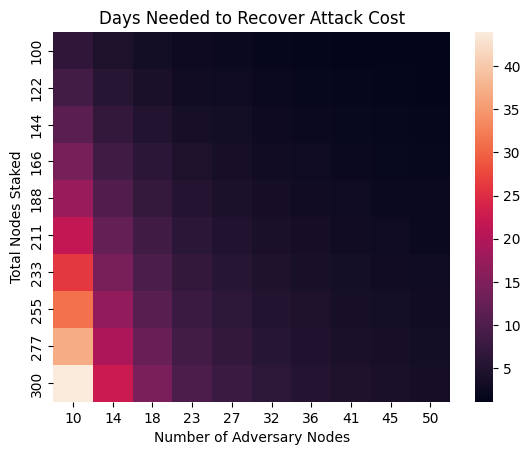

In [7]:

plt.figure()
plt.title('Days Needed to Recover Attack Cost')
sns.heatmap(pd.pivot_table(prob_df2, values='days', index='total_nodes', columns='attacker_nodes'))
plt.xlabel('Number of Adversary Nodes')
plt.ylabel('Total Nodes Staked')
plt.show()

# Pocket Simulation Model - cadCAD Modeling

Here the statistics model is tested against the cadCAD model of the Pocket Network.
This model was forked from the [official repository](https://github.com/BlockScience/PocketSimulationModel) and adapted to be able to implement the requiered mechanisms.
Please see at the end of the notebook a list of changes and issues.

In [8]:
import os, sys
sys.path.append('../')
os.chdir('../')


In [ ]:
from model import run_experiments

In [10]:
from model.config import experimental_setups, state, params
from model.classes import Application, Servicer

# We need to add at least one honest app or the simulation fails
# TODO: Fix that...
honest_apps = 1
adversary_apps = 1
# Select an arbitrary number of adversary nodes and total nodes to test
adversary_servicers = 30
honest_servicers = 300-adversary_servicers


################################################################################
# Below the experiment is constructed, this is not nice but thats the fastest
# way to do it.

# If you are looking for parameters of the network, look here, everything is 
# set-up in this cell.

# TODO: Add more montecarlo tests, convert to proper code
################################################################################

experimental_setups["custom_gaming"] = {
    "config_option_state": "custom_gaming",
    "config_option_params": "custom_gaming",
    "monte_carlo_n": 1,
    "T": 400,
}


state.config_option_map["custom_gaming"]= {
        "Geozones": "Test",
        "Applications": "custom_gaming",
        "DAO": "Test",
        "Gateways": "Test",
        "Services": "Test",
        "Servicers": "custom_gaming",
        "Validators": "Test",
    }


state.application_config['custom_gaming'] = list()
# Add honest apps
for i in range(honest_apps):
    state.application_config['custom_gaming'].append(Application(
            name="honest_%d"%i,
            pokt_holdings=15000 * 1e6,
            staked_pokt=15000 * 1e6,
            services=[],
            geo_zone="Zone 1",
            number_of_services=1,
            stake_status="Staked",
            unstaking_height=None,
            delegate=None,
            uses_gateway=False,
        ),)
# Add adversary apps
for i in range(adversary_apps):
    state.application_config['custom_gaming'].append(Application(
            name="adversary_%d"%i,
            pokt_holdings=15000 * 1e6,
            staked_pokt=15000 * 1e6,
            services=[],
            geo_zone="Zone 1",
            number_of_services=1,
            stake_status="Staked",
            unstaking_height=None,
            delegate=None,
            uses_gateway=False,
        ),)



state.servicers_config['custom_gaming'] = list()
# Add honest nodes
for i in range(honest_servicers):
    state.servicers_config['custom_gaming'].append(
        Servicer(
            name="honest_{}".format(i),
            servicer_salary=0,
            report_card=None,
            test_scores = {"last_sample_height": -1,
                        "total_samples": -1,
                        "botom_N": None,
                        "data_accuracy": 1.0,
                        "average_latency": 0.0,
                        },
            pokt_holdings=0,
            staked_pokt=15000 * 1e6,
            service_url=None,
            services=[],
            geo_zone="Zone 1",
            operator_public_key=None,
            pause_height=None,
            stake_status="Staked",
            unstaking_height=None,
            QoS=1.0, # All start as honest
        ),)
# Add adversary servicers
for i in range(adversary_servicers):
    state.servicers_config['custom_gaming'].append(
        Servicer(
            name="adversary_{}".format(i),
            servicer_salary=0,
            report_card=None,
            test_scores={"last_sample_height": -1,
                        "total_samples": -1,
                        "botom_N": None,
                        "data_accuracy": 1.0,
                        "average_latency": 0.0,
                        },
            pokt_holdings=0,
            staked_pokt=15000 * 1e6,
            service_url=None,
            services=[],
            geo_zone="Zone 1",
            operator_public_key=None,
            pause_height=None,
            stake_status="Staked",
            unstaking_height=None,
            QoS=1.0, # All start as honest
        ),)
    

params.config_option_map["custom_gaming"] = {"System": "custom_gaming", "Behaviors": "custom_gaming", "Functional": "custom_gaming"}


params.system_param_config["custom_gaming"] = deepcopy(params.system_param_config["Test"])
params.system_param_config["custom_gaming"]["granularity"] = ["session"]
params.system_param_config["custom_gaming"]["minimum_servicers_per_session"] = [24]
params.system_param_config["custom_gaming"]["maximum_servicers_per_session"] = [24]
params.system_param_config["custom_gaming"]["implicit_QoS"] = [True]
params.system_param_config["custom_gaming"]["implicit_QoS_memory"] = [4]
params.system_param_config["custom_gaming"]["implicit_QoS_low_k"] = [3]
params.system_param_config["custom_gaming"]["implicit_QoS_max_low"] = [3]
params.system_param_config["custom_gaming"]["application_fee_per_relay"] = [burn_per_relay] # Current price at pokt 0.2
params.system_param_config["custom_gaming"]["gateway_fee_per_relay"] = [burn_per_relay]
params.system_param_config["custom_gaming"]["relays_to_tokens_multiplier"] = [mint_per_relay]





params.behavior_param_config["custom_gaming"] = deepcopy(params.behavior_param_config["Test"])
params.behavior_param_config["custom_gaming"]["average_session_per_application"] = [1]
# Theese must be set to the maximum you wish to see, otherwise their numbers will grow over timestep (randomly)
params.behavior_param_config["custom_gaming"]["application_max_number"] =  [honest_apps+adversary_apps]
params.behavior_param_config["custom_gaming"]["servicer_max_number"] =  [honest_servicers+adversary_servicers]
params.behavior_param_config["custom_gaming"]["service_max_number"] =  [1]
# This tells you how many nodes the app requests
params.behavior_param_config["custom_gaming"]["applications_use_min_servicers"] =  [24]
params.behavior_param_config["custom_gaming"]["applications_use_max_servicers"] =  [24]

params.behavior_param_config["custom_gaming"]["application_leave_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["gateway_leave_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["service_leave_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["servicer_leave_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["service_unlinking_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["gateway_undelegation_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["servicer_jailing_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["uses_gateway_probability"] =  [0.0]
params.behavior_param_config["custom_gaming"]["service_linking_probability_normal"] =  [0.0]
params.behavior_param_config["custom_gaming"]["service_linking_probability_just_joined"] =  [0.0]
params.behavior_param_config["custom_gaming"]["kick_bottom_probability"] =  [0.0]
        
params.functional_param_config["custom_gaming"] = deepcopy(params.functional_param_config["Test"])
# params.functional_param_config["custom_gaming"]["submit_relay_requests_function"] = ["basic_gamma"]
params.functional_param_config["custom_gaming"]["submit_relay_requests_function"] = ["app_looper_test"]
params.functional_param_config["custom_gaming"]["app_looper_test_fixed_relays"] = [max_relays_per_session/10]

# custom_sweep = params.build_params("Base")
# CORE_PARAM_KEYS = sorted(list(custom_sweep.keys()))
# custom_sweep["application_max_number"] = [20, 30, 40]
# custom_sweep["servicer_max_number"] = [20, 30, 40]
# custom_sweep["relays_per_session_gamma_distribution_scale"] = [200000, 300000, 400000]

# _ = params.create_sweep("custom_gaming", custom_sweep, params.config_option_map_sweep)


for key in params.config_option_map_sweep:
    params.config_option_map_sweep[key]["dao_fee_percentage"] = [
        1 - params.config_option_map_sweep[key]["validator_fee_percentage"][0]
    ]

In [ ]:
# Create experiment and run, this will take a minute at least.

# df = run_experiments(["implicit_qos_test"])
df = run_experiments(["custom_gaming"])

### cadCAD Run Finished
Lets get the data

In [12]:
# Double check number of adversary nodes
num_honest = 0
num_adversary = 0
for svc in df[0]['Servicers'].values[-1]:
    if 'adversary' in svc.name:
        num_adversary +=1
    else:
        num_honest +=1
print(num_honest, num_adversary)

270 30


In [13]:
# Double check number of adversary apps
num_honest_apps = 0
num_adversary_apps = 0
for svc in df[0]['Applications'].values[-1]:
    if 'adversary' in svc.name:
        num_adversary_apps +=1
    else:
        num_honest_apps+=1
print(num_honest_apps, num_adversary_apps)

1 1


In [14]:
# Get relays for adversary or honest
honest_relays = list()
adversary_relays = list()
for log in df[0]['servicer_relay_log'].values:
    if log == None:
        # Ignore first step
        continue
    aux_honest = 0
    aux_adversary = 0
    
    for servicer in log.keys():
        if 'adversary' in servicer.name:
            aux_adversary += log[servicer]
        else :
            aux_honest += log[servicer]
    adversary_relays.append(aux_adversary)
    honest_relays.append(aux_honest)


In [15]:
print(np.mean(adversary_relays))
print(np.mean(honest_relays))

2083333.54
1791666.46


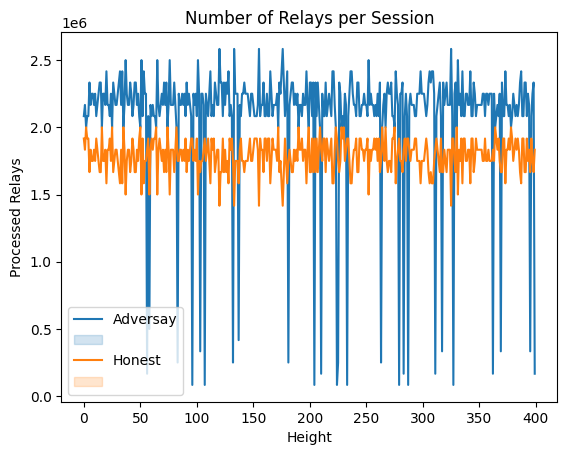

In [16]:
plt.figure()
sns.lineplot(adversary_relays)
sns.lineplot(honest_relays)
plt.legend(['Adversay', '', 'Honest', ""])
plt.title("Number of Relays per Session")
plt.xlabel('Height')
plt.ylabel('Processed Relays')
plt.show()


In [17]:
# Calculate per node type (honest/adversary) the amount of POKT minted and the
# amount of POKT burnt by the adversary app

ini_hold_honest = 0
ini_hold_adversary = 0
for app in df[0]['Applications'].values[0]:
    if 'adversary' in app.name:
        ini_hold_adversary += (app.pokt_holdings+app.staked_pokt)
    else:
        ini_hold_honest += app.pokt_holdings+app.staked_pokt

data_rewards_df = list()
for idx, row in df[0].iterrows():
    
    # Servicers
    adversary_rewards = 0
    adversary_scores = list()
    adversary_penalized = 0
    honest_rewards = 0
    honest_scores = list()
    honest_penalized = 0
    for svc in row['Servicers']:
        if 'adversary' in svc.name:
            adversary_rewards+=svc.pokt_holdings
            if svc.test_scores['botom_N'] != None:
                adversary_scores.append(np.sum(svc.test_scores['botom_N']))
                if np.sum(svc.test_scores['botom_N']) > 3:
                    adversary_penalized += 1
            else:
                adversary_scores.append(0)

            
        else:
            honest_rewards+=svc.pokt_holdings
            if svc.test_scores['botom_N'] != None:
                honest_scores.append(np.sum(svc.test_scores['botom_N']))
                if np.sum(svc.test_scores['botom_N']) > 3:
                    honest_penalized += 1
            else:
                honest_scores.append(0)

    adversary_scores = np.mean(adversary_scores) if len(adversary_scores)>0 else 0
    honest_scores = np.mean(honest_scores) if len(honest_scores)>0 else 0

    # Application burn
    adversary_app_burn = 0
    for app in row['Applications']:
        if 'adversary' in app.name:
            adversary_app_burn += (app.pokt_holdings+app.staked_pokt)
    adversary_app_burn -= ini_hold_adversary



    data_rewards_df.append([row['height'], 'adversary', adversary_rewards, adversary_scores, adversary_penalized, adversary_app_burn])
    data_rewards_df.append([row['height'], 'honest', honest_rewards, honest_scores, honest_penalized, 0])
data_rewards_df = pd.DataFrame(data_rewards_df, columns=['height', 'type', 'rewards', 'score', 'penalized', 'app_burn'])

In [18]:
data_rewards_df.head(4)

,height,type,rewards,score,penalized,app_burn
0,0,adversary,0.000000e+00,0.00000,0,0.0
1,0,honest,0.000000e+00,0.00000,0,0.0
2,4,adversary,1.568958e+08,0.00000,0,-8500000.0
3,4,honest,1.349304e+09,0.02963,0,0.0


/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_88492/3540594402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evil_df['net_win'] = evil_df['rewards']*adversary_income_frac+evil_df['app_burn']-app_stake


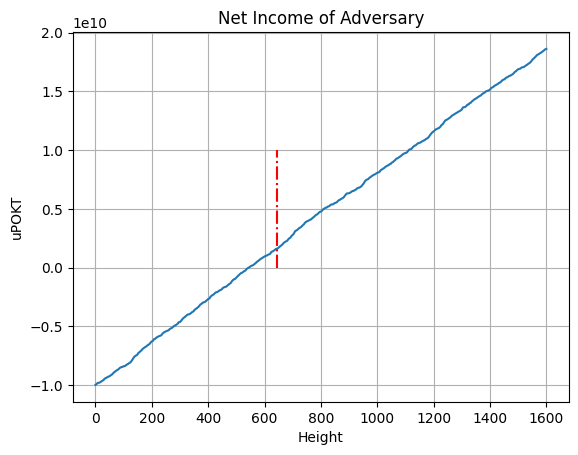

In [19]:
# On average we will earn this from self dealing (patching a limitation of current model)
# If we do not do this, the income from the honest app will show that the net income
# is above zero faster than expected.
adversary_income_frac = num_adversary_apps/(num_honest_apps+num_adversary_apps)

evil_df = data_rewards_df.loc[data_rewards_df['type']=='adversary']
evil_df['net_win'] = evil_df['rewards']*adversary_income_frac+evil_df['app_burn']-app_stake

plt.figure()
sns.lineplot(evil_df, x='height', y='net_win')
plt.grid()
# Add a line showing prediction location
plt.vlines([calc_attack_stats(num_adversary, (num_honest+num_adversary))[0]], ymin=0, ymax=1e10, colors='red',linestyles='-.')
plt.title("Net Income of Adversary")
plt.xlabel('Height')
plt.ylabel('uPOKT')
plt.show()


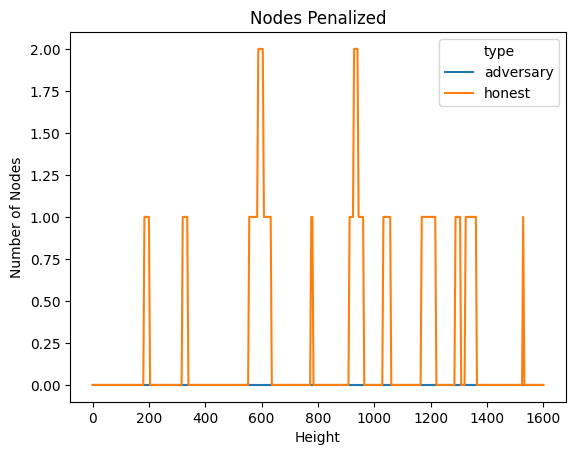

In [20]:
plt.figure()
sns.lineplot(data_rewards_df, x='height', y='penalized', hue='type')
plt.title("Nodes Penalized")
plt.xlabel('Height')
plt.ylabel('Number of Nodes')
plt.show()



In [21]:
# Calculate the penalization proportion per session
as_df = data_rewards_df.groupby('type').agg({
                                     'score' : 'mean',
                                     'penalized' : 'sum',
                                     'height' : 'count'})
as_df['prob_penalty_session'] = (as_df['penalized']/(as_df['height']*num_honest))
as_df

,score,penalized,height,prob_penalty_session
type,,,,
adversary,0.301579,0,401,0.000000
honest,0.684252,90,401,0.000831


### Misc. and WIP

Do not give much thought to this here

In [22]:
# Compare averages
for idx, row in data_rewards_df.tail(2)[['type', 'rewards']].iterrows():
    if row['type'] == 'adversary':
        avg_adversary = row['rewards']/num_adversary
        total_adversary = row['rewards']
    else:
        avg_honest = row['rewards']/num_honest
        total_honest = row['rewards']
print(avg_honest, avg_adversary)
print(avg_adversary/avg_honest)

1889839327.1333334 2120185649.4
1.121886722833774


In [23]:
# Stake is compensated with holdings, so, stake might not fall, actually it can grow using holdings.
ini_hold_honest = 0
ini_hold_adversary = 0
for app in df[0]['Applications'].values[0]:
    if 'adversary' in app.name:
        ini_hold_adversary += app.pokt_holdings+app.staked_pokt
    else:
        ini_hold_honest += app.pokt_holdings+app.staked_pokt

# Calculate final holdings
end_hold_honest = 0
end_hold_adversary = 0
for app in df[0]['Applications'].values[-1]:
    if 'adversary' in app.name:
        end_hold_adversary += app.pokt_holdings+app.staked_pokt
    else:
        end_hold_honest += app.pokt_holdings+app.staked_pokt

burn_adversary = end_hold_adversary-ini_hold_adversary

adversary_wins = total_adversary+burn_adversary

print(adversary_wins/num_adversary)
print(avg_honest)
print((adversary_wins/num_adversary)/avg_honest)



2013935649.4
1889839327.1333334
1.0656650120912163


In [24]:
data_rewards_df

,height,type,rewards,score,penalized,app_burn
0,0,adversary,0.000000e+00,0.000000,0,0.000000e+00
1,0,honest,0.000000e+00,0.000000,0,0.000000e+00
2,4,adversary,1.568958e+08,0.000000,0,-8.500000e+06
3,4,honest,1.349304e+09,0.029630,0,0.000000e+00
4,8,adversary,3.765500e+08,0.000000,0,-1.700000e+07
...,...,...,...,...,...,...
797,1592,honest,5.082797e+11,0.729630,0,0.000000e+00
798,1596,adversary,6.354281e+10,0.200000,0,-3.187500e+09
799,1596,honest,5.095977e+11,0.733333,0,0.000000e+00
800,1600,adversary,6.360557e+10,0.200000,0,-3.187500e+09


<Axes: xlabel='day', ylabel='total_relays'>

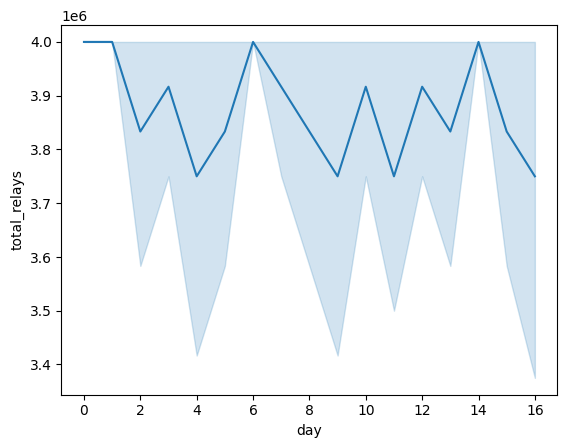

In [25]:
sns.lineplot(df[0], x='day', y='total_relays')

<Axes: xlabel='height', ylabel='total_relays'>

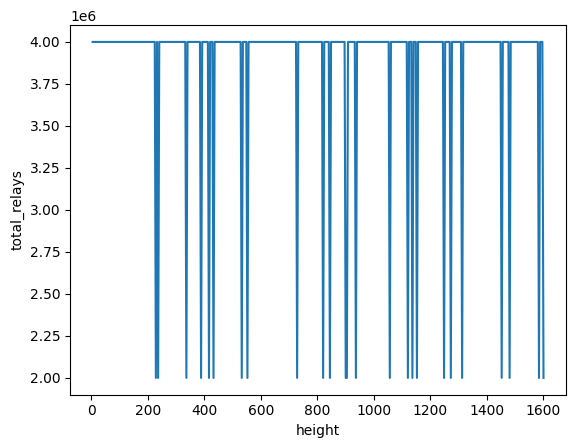

In [26]:
sns.lineplot(df[0], x='height', y='total_relays')

<Axes: xlabel='day', ylabel='total_relays'>

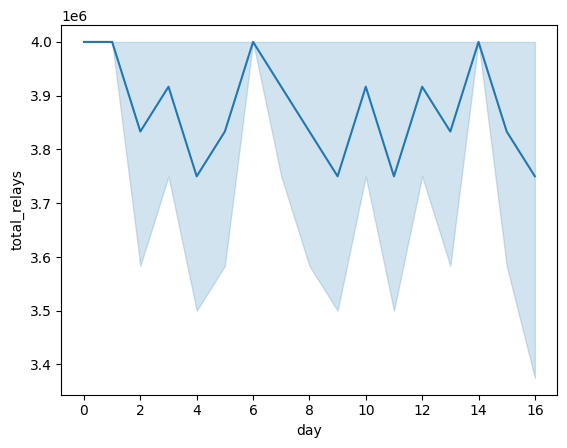

In [27]:
sns.lineplot(df[0], x='day', y='total_relays')

<Axes: xlabel='height', ylabel='POKT_minted'>

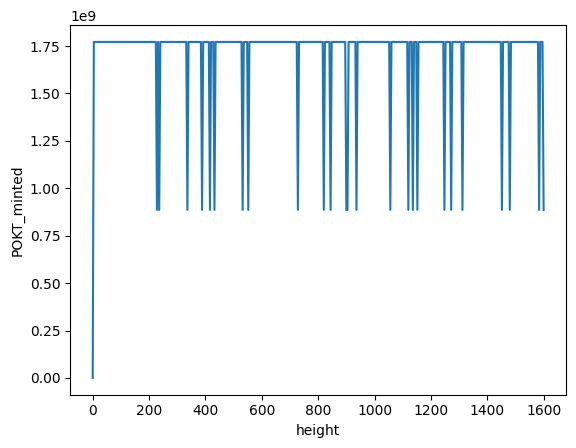

In [28]:
sns.lineplot(df[0], x='height', y='POKT_minted')

<Axes: xlabel='height', ylabel='POKT_minted'>

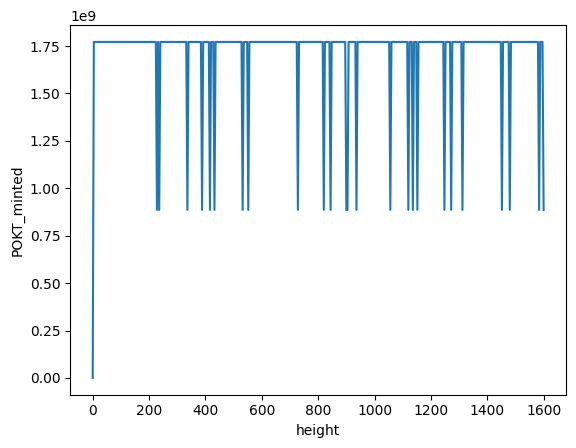

In [29]:
sns.lineplot(df[0], x='height', y='POKT_minted')

In [30]:
df[1].columns

Index(['Net Minting Rate', 'KPI C', 'Experiment Name', 'State Set',
       'Params Set', 'timestep', 'param_granularity',
       'param_minimum_stake_servicer', 'param_minimum_stake_period_servicer',
       'param_minimum_pause_time',
       ...
       'circulating_supply', 'dao_value_capture', 'POKT_burned_cummulative',
       'POKT_minted_cummulative', 'POKT_net_mint_cummulative',
       'burn_rate_cummulative', 'mint_rate_cummulative',
       'net_mint_rate_cummulative', 'kpi_c_pre', 'kpi_c_post'],
      dtype='object', length=109)

# PocketSimulationModel

### changes
- [Added] Comments everywhere...
- [Updated] "requeriments.txt" to incllude missing packages.
- [Updated] "README.md", bad enumartion format.
- [Fix] Height was updated wrongly, using `60*60*24` blocks per day instead of `24*60/15=96`
- [Added] New boundary action `submit_relay_requests_ba_test_app_looper` that goes though each app to create relays.
- [Added] `Application` has a `session_use_prob` field to use with `submit_relay_requests_ba_test_app_looper`. This parameter reflects wether or not an app chooses to use its session.
- [Fix] `Application` now has a `number_servicers` field be default.
- [Added] Self-dealing mechanism for all servicers and applications whose name has `adversary`. When a `adversary` app is selected it will try to deal all of its relays to a `adversary` servicer, if none is in the session it will just do round-robin.
- [Fix] `assign_servicer_salary_policy` was not using the session nodes, it rewarded all staked nodes.
- [Modified] `ServicerTestScoresType` was not being used, I modified it to make room for implicit QoS testing.
- [Added] Implicit QoS mechanics to keep track of nodes that are not given relays by gateways/apps and punish them if they are consistently ignored by them.
- [Modified] In `relay_request_ac`, the number of relays done, tracked by `processed_relays`, is now updated after the relay policy, because adversary nodes will change their relaying depending on current session, wich is not observed untill that point.



### Isues
- `p_relay_requests` takes the average sessions per app parameter and the total number of apps to then get the totol  sessions to process, but in each loop the used app is randomly chosen, not sure it this is OK when we need to do A/B testing on groups of apps...
- `submit_relay_requests_policy_test` baypases the relay generation process, but it seems not to be in use.



### Notes
- `application_join_ba_simple_unfiform` will always try to fill the total number of apps given. The maximum number of apps/services/servicers/gateways will grow up to the maximum given. This is OK, but you must not overlook that value when setting the parameters.

### Questions
- `relay_multiplier` not sure how this works.
- `submit_relay_requests_policy_test` / `submit_relay_requests_policy_v1` is using the number of services to calculate how many servicers are there in a session?. Also in `application_join_policy` this value is mixed `"number_servicers": application.number_of_services,`. Finally, `number_servicers` is not part of the application class, so it does not exist when added.

